# DL-based Stock Price Prediction Notebook
Starting with an LSTM-based predictor, inspired by https://github.com/jinglescode/time-series-forecasting-pytorch/tree/main (also on https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)

In [91]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal

from prompt_toolkit.shortcuts import set_title
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [92]:
ROOT = Path().resolve().parent
DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_trading_prices"
MINUTELY_PRICES = DATA / "minutely_trading_prices"

HISTORICAL_PRICES = DAILY_PRICES / "20250505 14_56_24 ^GDAXI Close price data 1987-12-30 to 2025-05-05.csv"

## LSTM Development

### Data Loading

In [93]:
price_column = 'Close'
date_column = 'Datetime'

price_file = pd.read_csv(HISTORICAL_PRICES)
price_file.dropna(axis=0, inplace=True)
price_file[date_column] = pd.to_datetime(price_file[date_column])
price_file[price_column] = price_file[price_column].astype(float) 

price_series = price_file.set_index(date_column)[price_column]
price_series

Datetime
1987-12-30     1005.190002
1988-01-04      956.489990
1988-01-05      996.099976
1988-01-06     1006.010010
1988-01-07     1014.469971
                  ...     
2025-04-28    22271.669922
2025-04-29    22425.830078
2025-04-30    22496.980469
2025-05-02    23086.650391
2025-05-05    23280.330078
Name: Close, Length: 9441, dtype: float64

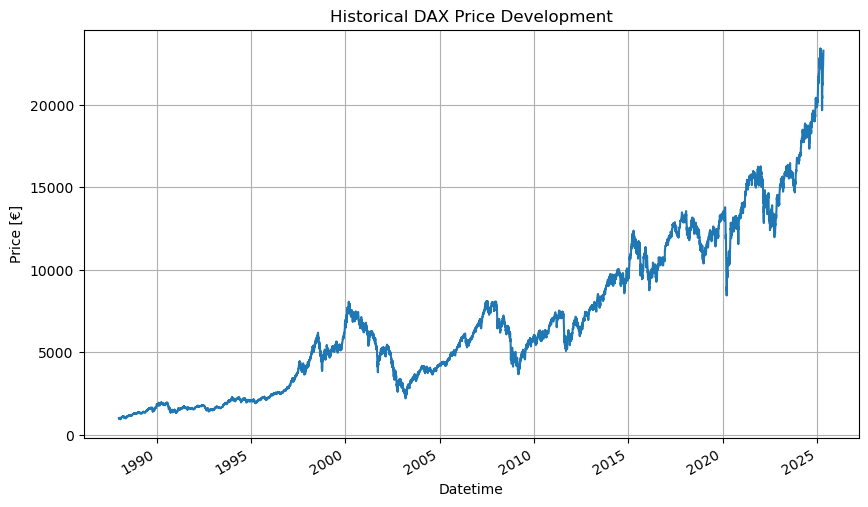

In [94]:
price_series.plot(ylabel='Price [€]', title='Historical DAX Price Development', figsize=(10, 6))
plt.grid()

### Data Preparation

#### Normalisation
Scaling the data is important for convergence during model training. We utilise the *normalisation* technique.

In [95]:
class Normaliser():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        """ Normalise an array of values. """
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        """ Reverse-transform an array of normalised values. """
        if self.sd is None: raise AttributeError("Please use fit_transform first so this instance remembers the respective std. and mean values!")
        return (x*self.sd) + self.mu

In [96]:
normaliser = Normaliser()
normalised_price_series = normaliser.fit_transform(price_series)
normalised_price_series

Datetime
1987-12-30   -1.256058
1988-01-04   -1.266210
1988-01-05   -1.257953
1988-01-06   -1.255887
1988-01-07   -1.254123
                ...   
2025-04-28    3.177085
2025-04-29    3.209221
2025-04-30    3.224053
2025-05-02    3.346973
2025-05-05    3.387347
Name: Close, Length: 9441, dtype: float64

#### Training Data
Split a share of the data (with the most recent datapoints) for model validation. 

We will train the model to predict the (rolling_window_size+1)th price based on the past (rolling_window_size) prices.

In [97]:
validation_split = 0.2
rolling_window_size = 20
sampling_rate = 'day'

In [98]:
# sliding window view as matrix: last column are current prices, 1st to (rolling-window-size - 1)th column are retrospective prices
# other possibility but apparently less safe:
#   np.lib.stride_tricks.as_strided(X, shape=(len(X) - rolling_window_size + 1, rolling_window_size), strides=(X.strides[0], X.strides[0]))[:-1]
X = np.lib.stride_tricks.sliding_window_view(normalised_price_series.to_numpy(), window_shape=rolling_window_size)[:-1]  # last row (latest value) is removed (because contained only in target values)
X

array([[-1.25605768, -1.26620953, -1.25795256, ..., -1.26375599,
        -1.26554664, -1.27011393],
       [-1.26620953, -1.25795256, -1.25588675, ..., -1.26554664,
        -1.27011393, -1.27048081],
       [-1.25795256, -1.25588675, -1.25412321, ..., -1.27011393,
        -1.27048081, -1.26724973],
       ...,
       [ 3.15453434,  3.23301629,  3.20192691, ...,  3.17099388,
         3.17708513,  3.20922087],
       [ 3.23301629,  3.20192691,  3.06154183, ...,  3.17708513,
         3.20922087,  3.22405265],
       [ 3.20192691,  3.06154183,  2.8373111 , ...,  3.20922087,
         3.22405265,  3.34697337]], shape=(9421, 20))

In [99]:
# target values are current prices, here the first 20 values have to be removed because of the moving window:
Y = normalised_price_series.to_numpy()[rolling_window_size:]
Y

array([-1.27048081, -1.26724973, -1.26638047, ...,  3.22405265,
        3.34697337,  3.38734722], shape=(9421,))

Using last 20.0% of data for validation. Other data for training.


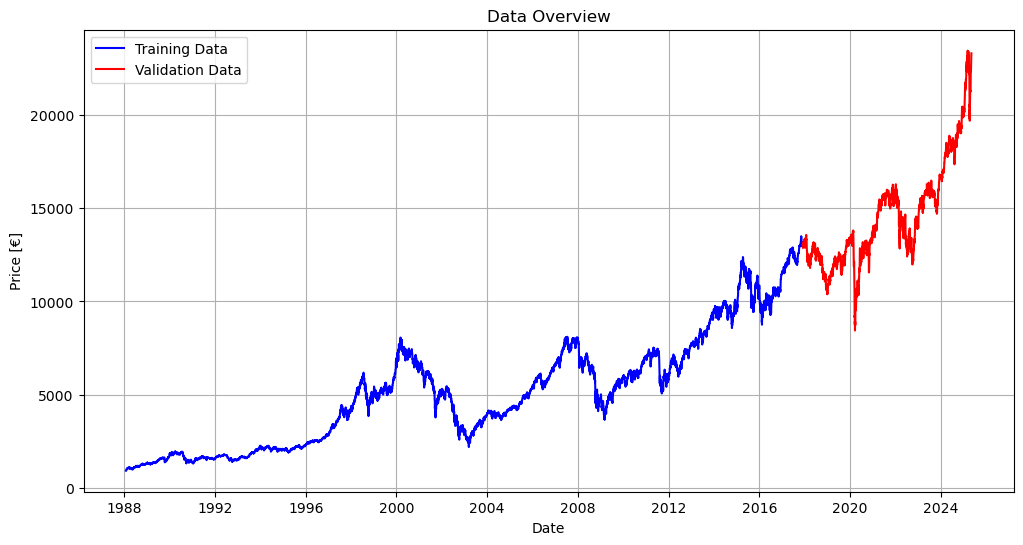

In [129]:
# split prices into training and validation data:
print(f"Using last {100 * validation_split}% of data for validation. Other data for training.")
validation_split_index = int(X.shape[0] * (1-validation_split))
X_train = X[:validation_split_index]
X_val = X[validation_split_index:]
Y_train = Y[:validation_split_index]
Y_val = Y[validation_split_index:]

# retrieve y-dates for plotting:
dates = normalised_price_series.index.to_numpy()[rolling_window_size:]
dates_train = dates[:validation_split_index]
dates_val = dates[validation_split_index:]

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train, normaliser.inverse_transform(Y_train), label='Training Data', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(Y_val), label='Validation Data', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

#### Pytorch Dataset and DataLoader

In [101]:
from typing import Union

class TimeSeriesDataset(Dataset):
    """ Time-series dataset class based on torch.utils.data.Dataset compatible torch.utils.data.DataLoader """
    def __init__(self,
                 X: Union[pd.DataFrame, pd.Series, np.ndarray],
                 Y: Union[pd.Series, pd.Series, np.ndarray]):
        # convert values to numpy if necessary:
        if isinstance(X, (pd.Series, pd.DataFrame)):
            X = X.to_numpy()
        if isinstance(Y, (pd.Series, pd.DataFrame)):
            Y = Y.to_numpy()
            
        # expand tensor for LSTM input:
        X = np.expand_dims(X, 2)
        
        # save values:
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)
        
        # information:
        print(f"Dataset Shape: {self.X.shape}, {self.Y.shape}")
        
    # necessary operators:
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [102]:
dataset_train = TimeSeriesDataset(X_train, Y_train)
dataset_val = TimeSeriesDataset(X_val, Y_val)

Dataset Shape: (7536, 20, 1), (7536,)
Dataset Shape: (1885, 20, 1), (1885,)


In [103]:
batch_size = 64  # number of data_points to be used during training

# a data loader is an efficient data generation scheme that
# combines a dataset and a sampler, and provides an iterable over the given dataset:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

### Define LSTM
LSTM is a specialized artificial neural network architecture that can **"memorize" patterns from historical sequences of data** and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called **Recurring Neural Networks (RNNs)**.

LSTMs overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the **vanishing gradients problem**, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain **memory cells and corresponding gate units**. More info: https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

In [115]:
class LSTMModel(nn.Module):
    """ LSTM model class based on torch.nn.Module """
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)  # transform feature into size of lstm hidden layers
        self.relu = nn.ReLU()  # non-linearity
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # prevent overfitting
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)  # transform LSTM output into output size
        
        self.init_weights()  # empirically accelerates convergence
        
    def init_weights(self):
        for name, param in self.named_parameters():  # iterate through weights and biases
            if 'bias' in name:  # bias zero initialisation: neutral starting point
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:  # input-hidden weights with He/Kaiming initialisation w. normal distribution: preserves gradient magnitude through ReLU activations
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:  # hidden-hidden weights with orthogonal matrix initialisation: maintains norm during sequence processing and helps prevent gradient issues
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        """ Forward call of module """
        batchsize = x.shape[0]
        
        # layer 1:
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer(s):
        lstm_out, (h_n, c_n) = self.lstm(x)
        # - lstm_out contains **all hidden states for the last layer** for every time step, used for tasks requiring per-time-step predictions
        # - h_n is a tensor containing the **final hidden state for each layer** in the sequence, used for initialing latter sequences or as **summarisation for classification tasks** (our purpose)
        # - c_n is a tensor containing the **final cell state for each layer** in the sequence
        # we utilise **h_n** because it aggregates states from all layers.
        
        # reshape final hidden state output to (batchsize, features) for consecutive linear layer:
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        # permute rearranges the dimensions according to a specific order, -1 tells reshape to infer the correct size for that dimension
        
        # layer 2:
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:, -1]  # return last column of all batches (equals predictions)
    
    def fit(self, dataloader,  optimiser, scheduler, device='cpu', loss_criterion=nn.MSELoss(), is_training=False):
        """ One epoch of training (is_training=True) or validation (is_training=False), returns the respective loss and learning rate as tuple. """
        epoch_loss = 0
        
        if is_training: self.train()  # training mode activates Dropout and BatchNorm (updates running statistics with each batch)
        else: self.eval()  # evaluation mode for inference or testing
        
        # iterate through dataset's batches via provided dataloader instance:
        for idx, (x, y) in enumerate(dataloader):
            if is_training: optimiser.zero_grad()  # reset all gradients for next training step
            
            batchsize = x.shape[0]
            
            # move tensors to correct device:
            x = x.to(device); y = y.to(device)
            
            # compute output and loss:
            out = self(x)
            loss = loss_criterion(out.contiguous(), y.contiguous())  # enforces the tensors to be stored in a contiguous memory block
            
            if is_training:
                loss.backward()  # backpropagation, traverses computational graph in reverse applying the chain rule to compute gradients
                optimiser.step()  # optimise weights
                
            epoch_loss += (loss.detach().item() / batchsize)  # detach loss value from computational graph, final epoch loss is averaged batch loss
            
        # learning rate:
        lr = scheduler.get_last_lr()[0]
        
        return epoch_loss, lr
    
    def predict(self, dataloader, device='cpu'):
        """ Compute predictions (outputs) for all samples in a dataloader. """
        self.eval()  # inference mode
        predictions = np.array([])
        
        for idx, (x, y) in enumerate(dataloader):
            x = x.to(device)
            out = self(x)  # run model
            out = out.cpu().detach().numpy()
            predictions = np.concatenate((predictions, out))
        
        return predictions
        

### Model Training
For training we utilise the **Adam optimiser** with **StepLR scheduler** to sequentially reduce the learning rate (other possibility: **ReduceLROnPlateau scheduler**) and **MSE-loss**

In [138]:
# model parameters:
model_input_size = 1
hidden_lstm_layer_size = 32
num_lstm_layers = 2
dropout = 0.2  # regularizer to prevent overfitting
use_mps_if_available = False  # in this case the CPU has often been faster than MPS 

if torch.cuda.is_available():
    device = torch.device('cuda')  # if ROCm is installed and AMD hardware is supported by such then 'cuda' also refers to AMD GPU acceleration. This however is not possible on mac
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
elif torch.backends.mps.is_available() and use_mps_if_available:
    device = torch.device('mps')
    print("Using GPU through Metal Performance Shaders (MPS) backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [ ]:
model = LSTMModel(input_size=model_input_size, hidden_layer_size=hidden_lstm_layer_size, num_layers=num_lstm_layers, output_size=1, dropout=dropout)

In [139]:
model = model.to(device)

In [140]:
# training parameters:
loss_criterion = nn.MSELoss()
scheduler_step_size = 40
initial_learning_rate = 0.01

In [141]:
def run_training(model, n_epochs: int, dataloader_train, dataloader_val, scheduler_step_size: int = 40, initial_learning_rate: float = 0.01, device='cpu', loss_criterion=nn.MSELoss()):
    # initialise optimiser and scheduler:
    optimiser = optim.Adam(model.parameters(), lr=initial_learning_rate, betas=(0.9, 0.98), eps=1e-9)  # beta and eps are standard values derived from github
    scheduler = optim.lr_scheduler.StepLR(optimiser, scheduler_step_size, gamma=0.1)
    
    # training loop:
    progress_bar = tqdm(range(n_epochs), desc=f'Training loss: - | Validation Loss: - | Learning rate: - | Training progress')
    loss_train_history, loss_val_history = [], []
    for _ in progress_bar:
        loss_train, lr_train = model.fit(dataloader_train, optimiser=optimiser, scheduler=scheduler, device=device, loss_criterion=loss_criterion, is_training=True)
        loss_val, _ = model.fit(dataloader_val, optimiser=optimiser, scheduler=scheduler, device=device, loss_criterion=loss_criterion, is_training=False)
        scheduler.step()
        
        loss_train_history.append(loss_train); loss_val_history.append(loss_val)
        progress_bar.desc = f'Training loss: {loss_train} | Validation Loss: {loss_val} | Learning rate: {lr_train} | Training progress'
    
    # result plot:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(range(n_epochs), loss_train_history, label='Training loss', color='blue')
    ax.plot(range(n_epochs), loss_val_history, label='Validation loss', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
    ax.set_title('Training Progress')

Training loss: 0.0032710390787542565 | Validation Loss: 0.007255842811869586 | Learning rate: 1.0000000000000002e-06 | Training progress: 100%|██████████| 200/200 [01:50<00:00,  1.81it/s] 


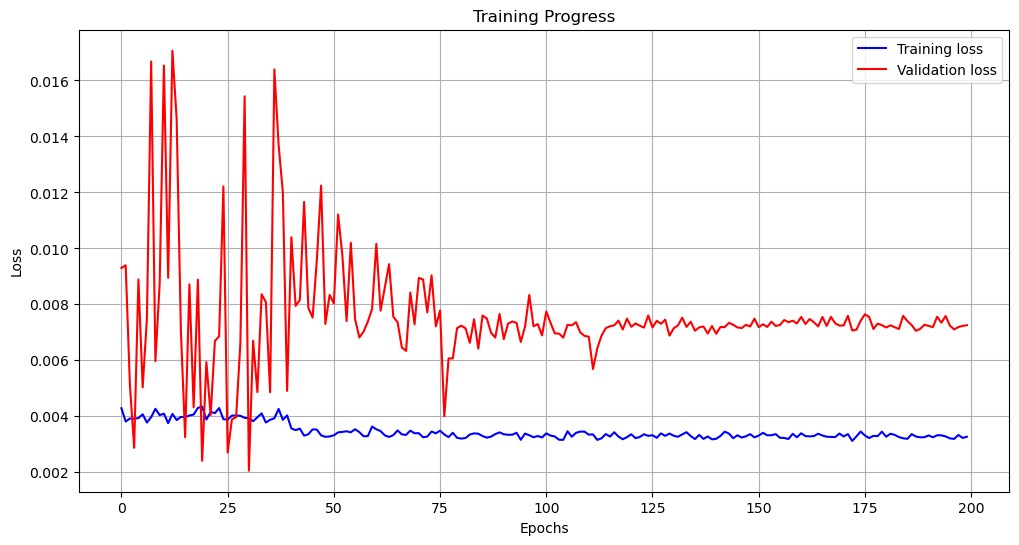

In [143]:
run_training(model, 200, dataloader_train, dataloader_val, scheduler_step_size, initial_learning_rate, device)

### Model Inference
Now we test the model for actual predictions.

In [144]:
train_predictions = model.predict(dataloader_train, device=device)
train_predictions

array([-2.31821239e-02, -9.41648483e-01,  6.85542822e-04, ...,
       -2.55719721e-01, -3.34666818e-01,  2.10794240e-01], shape=(7536,))

In [145]:
val_predictions = model.predict(dataloader_val, device=device)
val_predictions

array([1.29166675, 1.02960551, 1.72289741, ..., 1.65677679, 1.01961935,
       0.6697427 ], shape=(1885,))

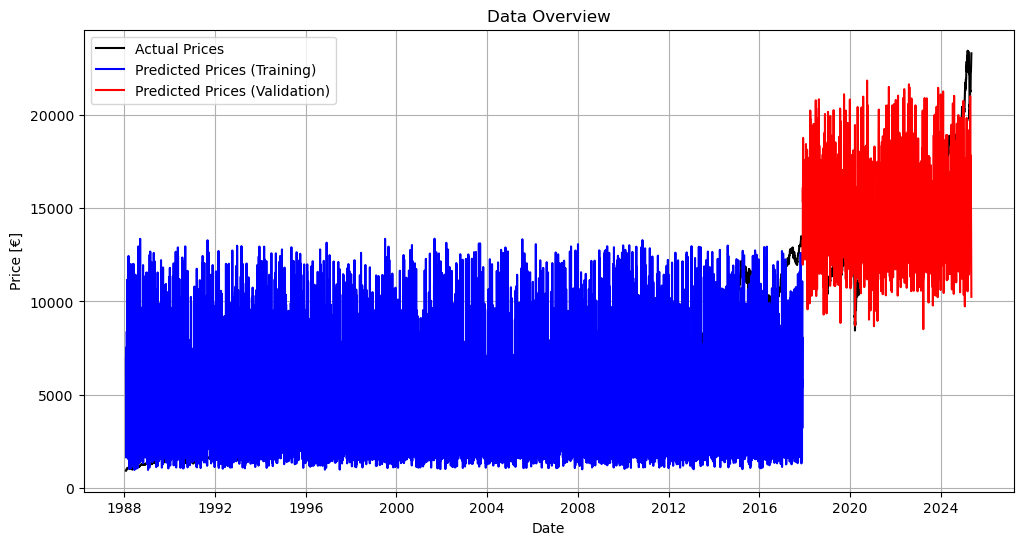

In [146]:
# plot result:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(dates, normaliser.inverse_transform(Y), label='Actual Prices', color='black')
ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(val_predictions), label='Predicted Prices (Validation)', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()